In [1]:
%%bash
git clone https://github.com/jthickstun/gm-hw2
wget https://courses.cs.washington.edu/courses/cse599i/20au/resources/data.tar.gz
tar -xf data.tar.gz

fatal: destination path 'gm-hw2' already exists and is not an empty directory.
--2025-04-13 00:14:51--  https://courses.cs.washington.edu/courses/cse599i/20au/resources/data.tar.gz


Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15729555 (15M) [application/x-gzip]
Saving to: ‘data.tar.gz.5’

     0K .......... .......... .......... .......... ..........  0%  360K 42s
    50K .......... .......... .......... .......... ..........  0%  721K 32s
   100K .......... .......... .......... .......... ..........  0% 67.8M 21s
   150K .......... .......... .......... .......... ..........  1% 79.9M 16s
   200K .......... .......... .......... .......... ..........  1%  725K 17s
   250K .......... .......... .......... .......... ..........  1% 72.4M 14s
   300K .......... .......... .......... .......... ..........  2%  241M 12s
   350K .......... .......... .......... .......... ..........  2% 9.20M 11s
   400K .......... .......... .......... .......... .........

In [1]:
import sys,os,signal
import numpy as np
import matplotlib.pyplot as plt
import torch

from time import time
from torchvision import transforms
from IPython import display

sys.path.append('gm-hw2')
import bmnist,losses,models

root = 'data/'

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN)
    
autoregress = False
batch_size = 100
kwargs = {'num_workers': 2, 'pin_memory': True, 'worker_init_fn': worker_init}

In [3]:
train_set = bmnist.BinarizedMNIST(root=root, train=True)
test_set = bmnist.BinarizedMNIST(root=root, train=False)

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False, **kwargs)

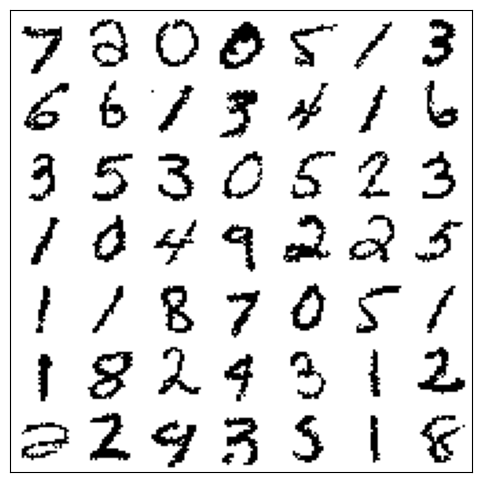

In [4]:
def print_images(x, ax, n=7, d=28, color='black'):
    ax.cla()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    panel = np.zeros([n*d,n*d])
    for i in range(n):
        for j in range(n):
            panel[i*d:(i+1)*d,j*d:(j+1)*d] = x[i*n+j,0]
            
    ax.imshow(panel, cmap=plt.get_cmap('Greys'))
    plt.setp(ax.spines.values(), color=color)

fig, ax = plt.subplots(figsize=(6,6))
            
for i, x in enumerate(train_loader):
    print_images(x, ax)
    break

In [6]:
g = models.DiscreteVAEDecoder(autoregress=autoregress).cuda()
f = models.VAEEncoder().cuda()
loss_func = losses.discrete_output_elbo

loss_train = []
loss_test = []
loss_r = []
loss_d = []

../aten/src/ATen/native/cuda/DistributionTemplates.h:598: operator(): block: [18,0,0], thread: [480,0,0] Assertion `0 <= p4 && p4 <= 1` failed.
../aten/src/ATen/native/cuda/DistributionTemplates.h:598: operator(): block: [18,0,0], thread: [481,0,0] Assertion `0 <= p4 && p4 <= 1` failed.
../aten/src/ATen/native/cuda/DistributionTemplates.h:598: operator(): block: [18,0,0], thread: [482,0,0] Assertion `0 <= p4 && p4 <= 1` failed.
../aten/src/ATen/native/cuda/DistributionTemplates.h:598: operator(): block: [18,0,0], thread: [483,0,0] Assertion `0 <= p4 && p4 <= 1` failed.
../aten/src/ATen/native/cuda/DistributionTemplates.h:598: operator(): block: [18,0,0], thread: [484,0,0] Assertion `0 <= p4 && p4 <= 1` failed.
../aten/src/ATen/native/cuda/DistributionTemplates.h:598: operator(): block: [18,0,0], thread: [485,0,0] Assertion `0 <= p4 && p4 <= 1` failed.
../aten/src/ATen/native/cuda/DistributionTemplates.h:598: operator(): block: [18,0,0], thread: [486,0,0] Assertion `0 <= p4 && p4 <= 1` 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


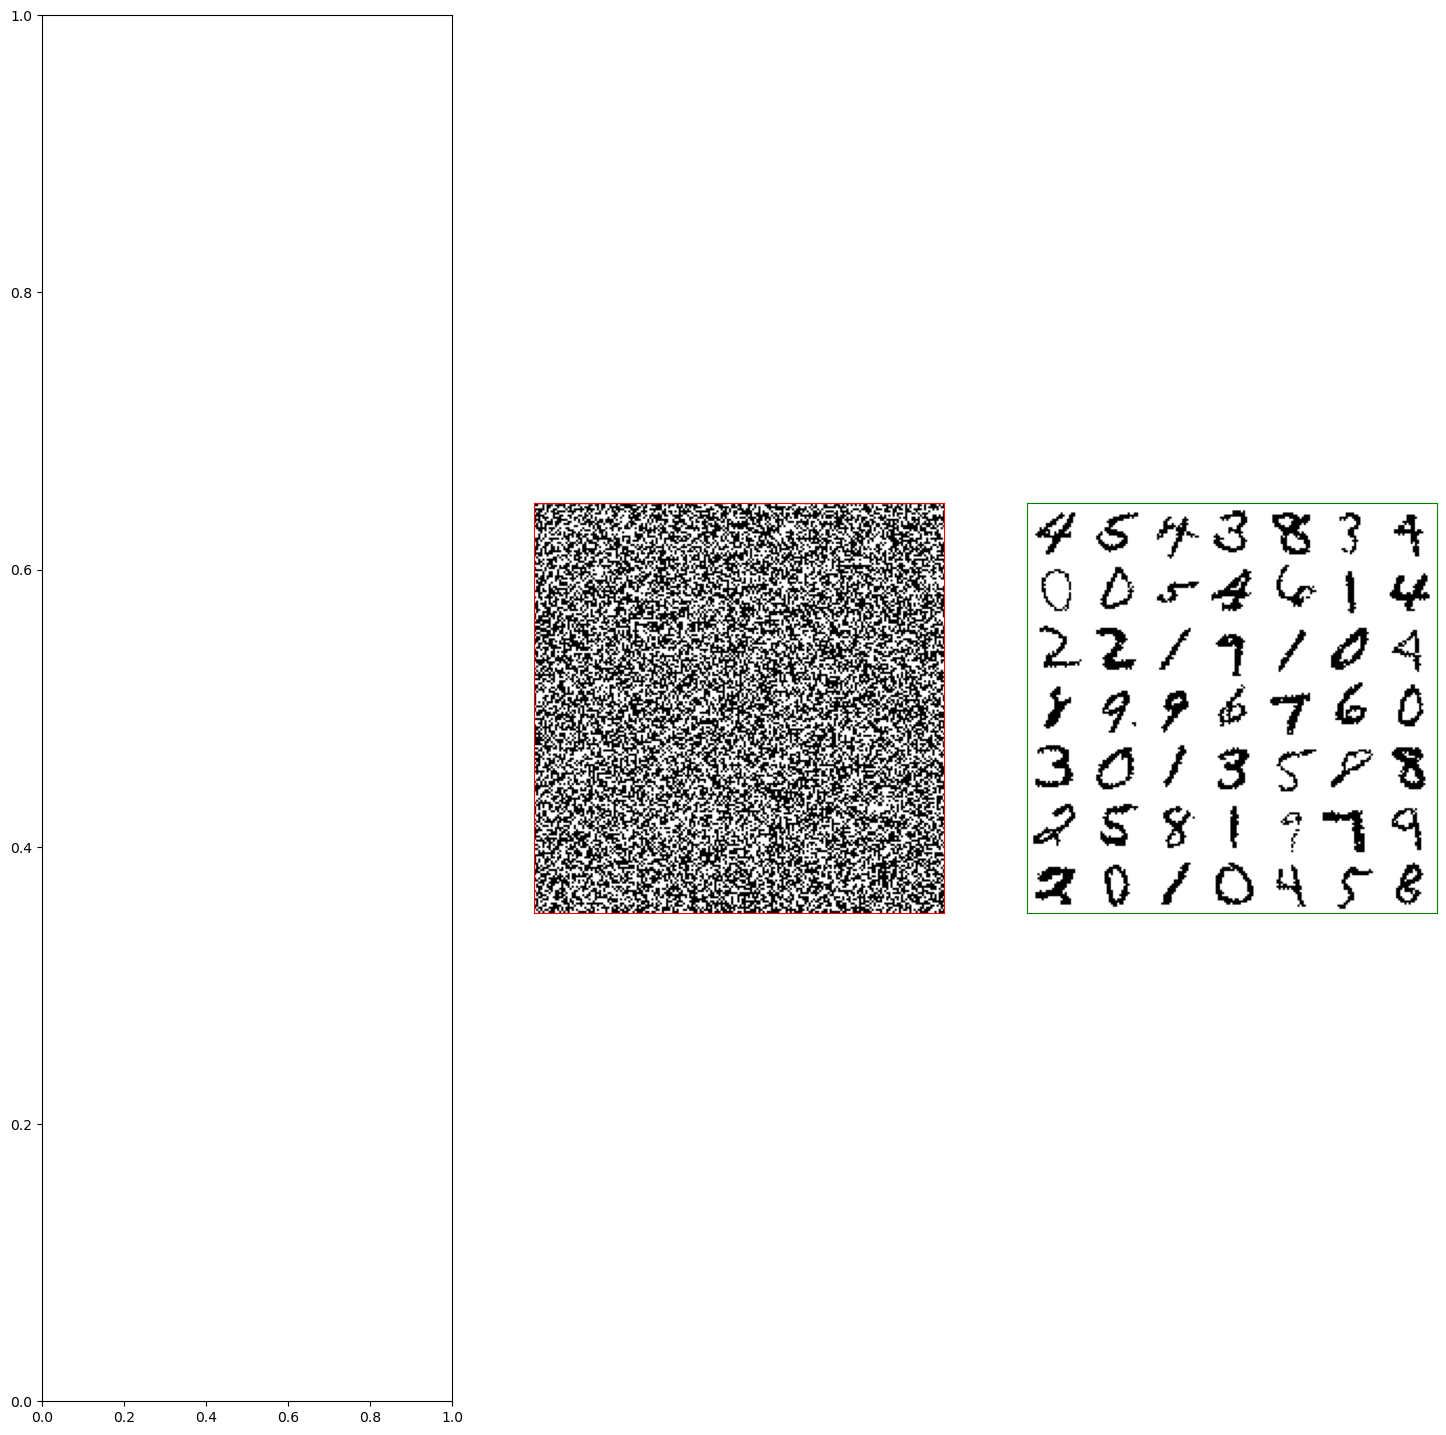

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(10,18))
fig.set_figwidth(18)

optimizer = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr=1e-3)
i = 0
t0 = time()
for epoch in range(60):
    if autoregress and epoch == 10: g.autoregress = True # after warmup, start autoregressive conditioning
    if epoch == 40: optimizer.param_groups[0]['lr'] = lr = 3e-4 # cut the learning rate
    for x in train_loader:
        x = x.cuda()
        
        optimizer.zero_grad()
        epsilon = torch.randn(batch_size,1,7,7).cuda()
        z, logqzx, _, _ = f(x, epsilon)
        
        recon,div = loss_func(g(z,x),x,z,logqzx)
        loss = recon + div
        
        loss.backward()
        optimizer.step()
        
        #
        # book-keeping after this
        #
        
        loss_train.append(loss.detach().cpu().numpy())
        loss_r.append(recon.detach().cpu().numpy())
        loss_d.append(div.detach().cpu().numpy())
        
        if i % 600 == 0:
            g.eval(); f.eval()
            fake = g.sample(torch.randn(batch_size,1,7,7).cuda())
            display.clear_output(wait=True)
            print_images(fake.detach().cpu(), ax[0], color='black')
            print_images(x.cpu(), ax[2], color='green')
            print_images(g.sample(z).detach().cpu(), ax[1], color='red')
            display.display(plt.gcf())
            
            losst = 0
            for x in test_loader:
                x = x.cuda()
                epsilon = torch.randn(batch_size,1,7,7).cuda()
                z, logqzx, _, _ = f(x, epsilon)
                
                recont,divt = loss_func(g(z,x),x,z,logqzx)
                losst += recont.detach() + divt.detach()
            
            losst = losst.cpu().numpy() / len(test_loader)
            print(i,time()-t0,loss_train[-1],losst)
            t0 = time()
            g.train(); f.train()
        loss_test.append(losst)
        i += 1

In [ ]:
start = 600
end = -1

fig, axes = plt.subplots(1,3)
fig.set_figwidth(18)
fig.set_figheight(5)

axes[0].set_title('likelihood value')
axes[0].plot(loss_train[start:end])
axes[0].plot(loss_test[start:end])
axes[1].set_title('divergence')
axes[1].plot(loss_d[start:end])
axes[2].set_title('reconstruction')
axes[2].plot(loss_r[start:end])

# Marginal Likelihood Estimation

In [ ]:
from scipy.special import logsumexp
import torch.nn.functional as F

M = 1000
B = 125

test_single_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=1,shuffle=False, **kwargs)
loglikelihood = []
g.eval(); f.eval()
for i,x in enumerate(test_single_loader):
    if i % 100 == 0: print(i,end=' ')
    x = x.cuda()
    epsilon = torch.randn(M,1,7,7).cuda()
    
    samples = []
    num_batches = M//B
    x = x.expand(B,1,28,28)
    for i in range(num_batches):
        z, logqzx, _, _ = f(x, epsilon[i*B:(i+1)*B])
        logpxz = F.binary_cross_entropy_with_logits(g(z,x), x, reduction='none').view(-1,784).sum(1)
        logpz = 0.5*z.pow(2).sum(1)
        
        samples.extend(-(logpxz + logpz - logqzx).detach().cpu().numpy())
    
    loglikelihood.append(logsumexp(np.array(samples)) - np.log(M))
g.train(); f.train()
print(-np.mean(loglikelihood))